In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/final_nba_data_2.csv'
data = pd.read_csv(file_path, encoding='latin1')


# 결측치가 있는 모든 행 제거
data_cleaned = data.dropna()

# Pos 열의 값이 특정 값인 행 제거
positions_to_remove = ['C-PF', 'PF-SF', 'PG-SG', 'SF-SG', 'SG-PG', 'SG-SF']
data_filtered = data_cleaned[~data_cleaned['Pos'].isin(positions_to_remove)]
data_filtered = data_filtered.drop(columns=['Pos'])
# 원-핫 인코딩된 열만 선택하여 int로 변환
encoded_columns = [col for col in data_filtered.columns if col.startswith('Pos_')]
data_filtered[encoded_columns] = data_filtered[encoded_columns].astype(int)
data_encoded = data_filtered

# target feature (목표 변수)
target = data_encoded['target']
# input feature (입력 변수들)
input_features = data_encoded.drop(columns=['name', 'target', 'salary'])

data_encoded = data_filtered
# target feature (목표 변수)
target = data_encoded['target']
# input feature (입력 변수들)
input_features = data_encoded.drop(columns=['name', 'target', 'salary'])
# 결과 데이터 확인
input_features.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
Index: 1551 entries, 0 to 1575
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start            1551 non-null   int64  
 1   GS               1551 non-null   float64
 2   MP               1551 non-null   float64
 3   FG               1551 non-null   float64
 4   FGA              1551 non-null   float64
 5   FG%              1551 non-null   float64
 6   3P               1551 non-null   float64
 7   3PA              1551 non-null   float64
 8   3P%              1551 non-null   float64
 9   2P               1551 non-null   float64
 10  2PA              1551 non-null   float64
 11  2P%              1551 non-null   float64
 12  eFG%             1551 non-null   float64
 13  FT               1551 non-null   float64
 14  FTA              1551 non-null   float64
 15  FT%              1551 non-null   float64
 16  ORB              1551 non-null   float6

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform, randint

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.3, random_state=42)

# 표준화 안 할 feature들
exclude_columns = ['Pos_PG', 'Pos_SG', 'Pos_SF', 'Pos_PF', 'Pos_C']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#표준화 할 feature들
columns_to_scale = [col for col in X_train.columns if col not in exclude_columns]

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


# RandomizedSearchCV를 통해, hyperparameter tuning.
xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3)
}
xgb_model = XGBRegressor(random_state=42)
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_params, cv=5, scoring='r2', n_iter=50, n_jobs=-1, random_state=42)
xgb_random_search.fit(X_train_scaled, y_train)

xgb_best_model = xgb_random_search.best_estimator_
xgb_train_pred = xgb_best_model.predict(X_train_scaled)
xgb_test_pred = xgb_best_model.predict(X_test_scaled)

xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)


ada_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 1)
}
ada_model = AdaBoostRegressor(random_state=42)
ada_random_search = RandomizedSearchCV(ada_model, ada_params, cv=5, scoring='r2', n_iter=50, n_jobs=-1, random_state=42)
ada_random_search.fit(X_train_scaled, y_train)

ada_best_model = ada_random_search.best_estimator_
ada_train_pred = ada_best_model.predict(X_train_scaled)
ada_test_pred = ada_best_model.predict(X_test_scaled)

ada_train_r2 = r2_score(y_train, ada_train_pred)
ada_test_r2 = r2_score(y_test, ada_test_pred)

# xgb와 ada의 ensemble인 stacking regressor model
estimators = [
    ('xgb', xgb_best_model),
    ('ada', ada_best_model)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
stacking_model.fit(X_train_scaled, y_train)

stacking_train_pred = stacking_model.predict(X_train_scaled)
stacking_test_pred = stacking_model.predict(X_test_scaled)

stacking_train_r2 = r2_score(y_train, stacking_train_pred)
stacking_test_r2 = r2_score(y_test, stacking_test_pred)

print(f"XGBoost - Train R²: {xgb_train_r2:.2f}, Test R²: {xgb_test_r2:.2f}")
print(f"AdaBoost - Train R²: {ada_train_r2:.2f}, Test R²: {ada_test_r2:.2f}")
print(f"Stacking - Train R²: {stacking_train_r2:.2f}, Test R²: {stacking_test_r2:.2f}")

XGBoost - Train R²: 0.99, Test R²: 0.80
AdaBoost - Train R²: 0.84, Test R²: 0.74
Stacking - Train R²: 0.90, Test R²: 0.70


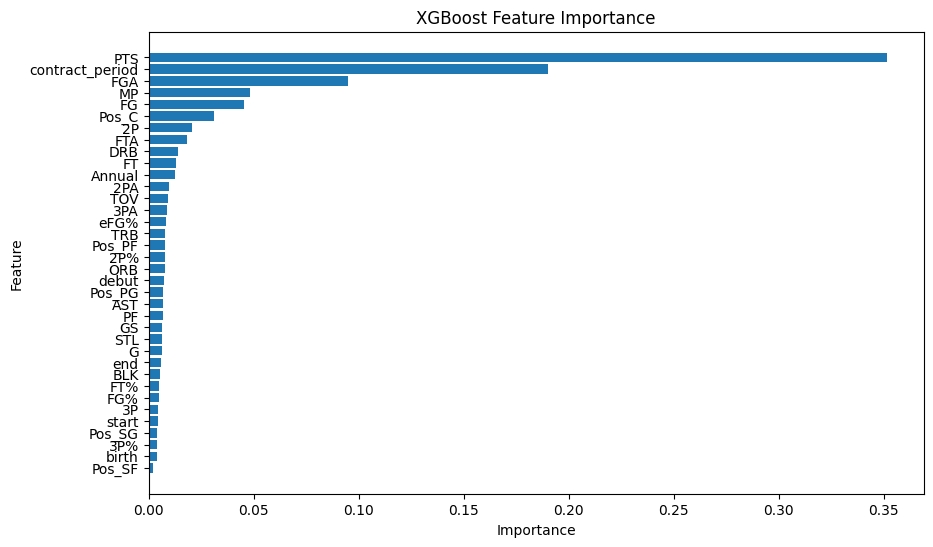

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import xgboost as xgb
from xgboost import plot_importance, plot_tree

feature_names = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
feature_importances = xgb_best_model.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature on top
plt.show()

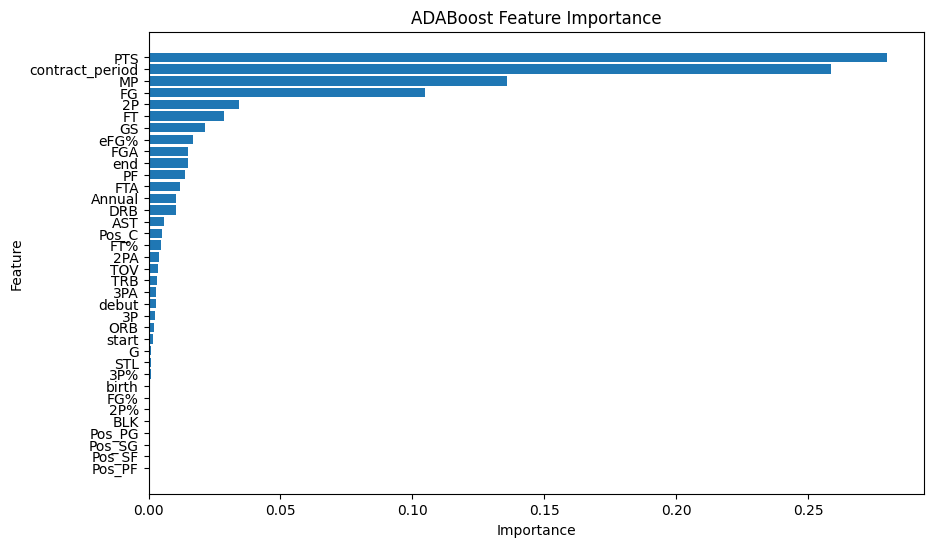

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import xgboost as xgb
from xgboost import plot_importance, plot_tree

feature_names = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
feature_importances = ada_best_model.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('ADABoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature on top
plt.show()

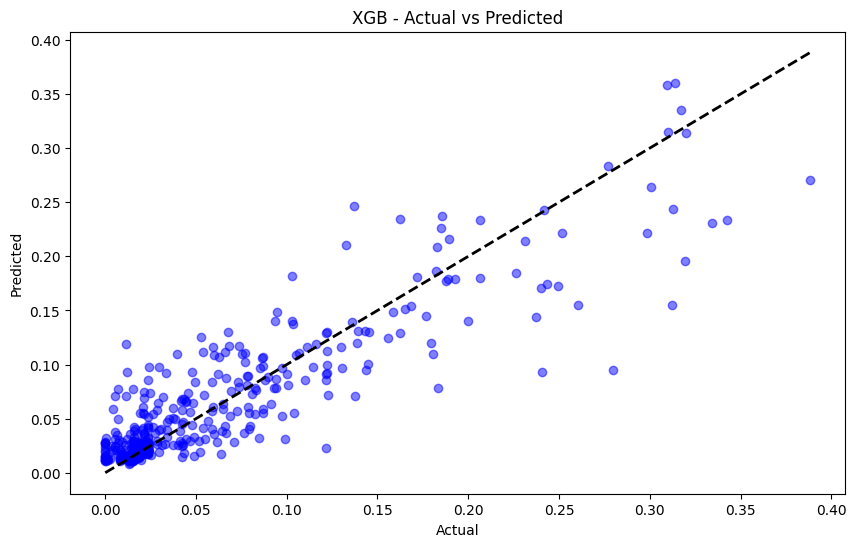

In [5]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGB - Actual vs Predicted')
plt.show()

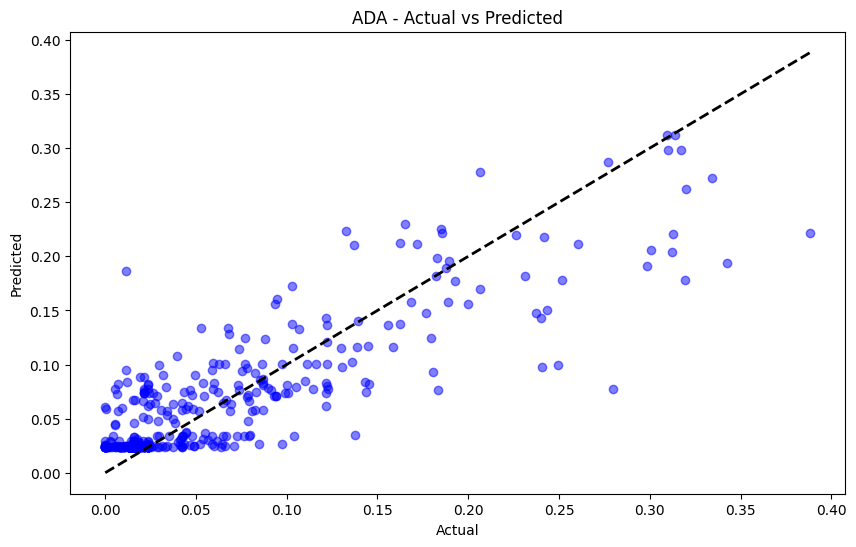

In [6]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ada_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ADA - Actual vs Predicted')
plt.show()

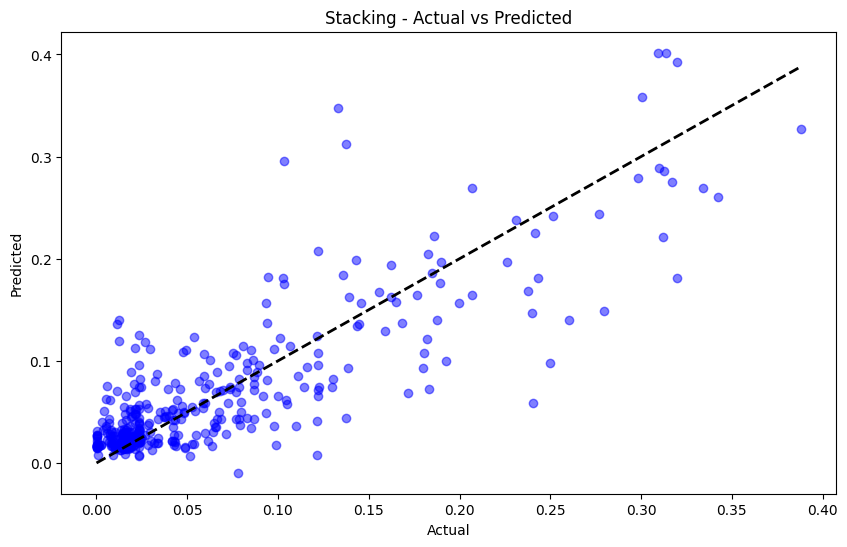

In [7]:
 # 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, stacking_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Stacking - Actual vs Predicted')
plt.show()